<a href="https://colab.research.google.com/github/Vik-Gt-321/Time-Series-Forecasting-of-Bitcoin/blob/main/BitPredictNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPool1D

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-11 13:53:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2021-08-11 13:53:17 (46.2 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=True, index_col="Date")

In [ ]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
len(df)

2787

In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)":"Price"})

In [ ]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


## Format data

In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

In [ ]:
timesteps[:2], prices[:2]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000'],
       dtype='datetime64[ns]'), array([123.65499, 125.455  ]))

In [ ]:
def plot_time_series(timesteps, values, format = ".", start =0, end =None, label= None):
  plt.plot(timesteps[start:end], values[start:end], format  , label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize =14)
  plt.grid()

In [ ]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

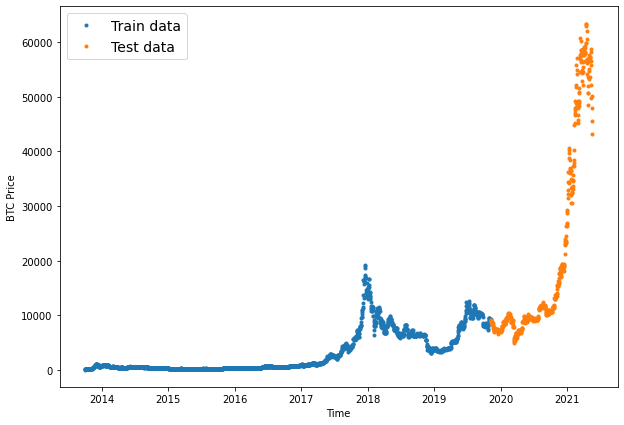

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(X_train,y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

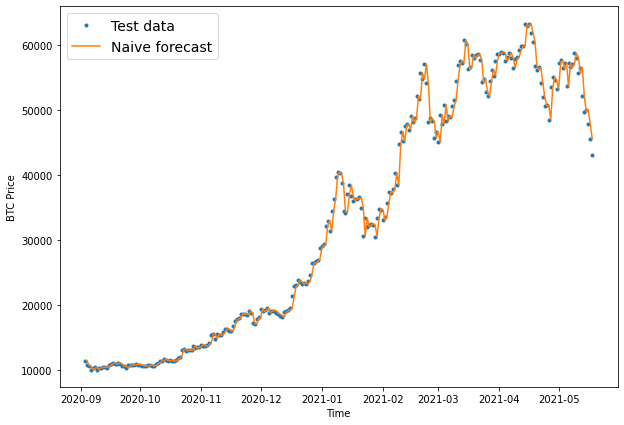

In [ ]:
naive_forecast  =y_test[:-1]
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Format data 2

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
def get_labelled_window(x, horizon = HORIZON):
  return x[:, :-horizon], x[: ,-horizon:]

In [ ]:
test_window, test_label  = get_labelled_window(tf.expand_dims(tf.range(8)+1, axis =0))

In [ ]:
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [ ]:
tf.expand_dims(tf.range(8)+1, axis =0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)>

In [ ]:
tf.range(8)+1

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)>

In [ ]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
def make_train_test_split(windows, labels, split = 0.2):
  split_size = int(len(windows)*(1-split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows,train_labels,  test_labels

In [ ]:
train_windows, test_windows,train_labels,  test_labels = make_train_test_split(full_windows, full_labels)

## Model CheckPoint

In [ ]:
import os
def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            verbose =0,
                                            save_best_only =1)

## Model 1

In [ ]:
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint("model1")])

INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/assets
INFO:tensorflow:Assets written to: model_experiments/model1/as

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [ ]:
model_1 = keras.models.load_model("/content/model_experiments/model1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 568.5499 - mae: 568.5499


[568.5498657226562, 568.5498657226562]

In [ ]:
def model_preds(model, input):
  preds = model.predict(input)
  return tf.squeeze(preds)

In [ ]:
model_1_preds = model_preds(model_1, test_windows)

In [ ]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)

In [ ]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [ ]:
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

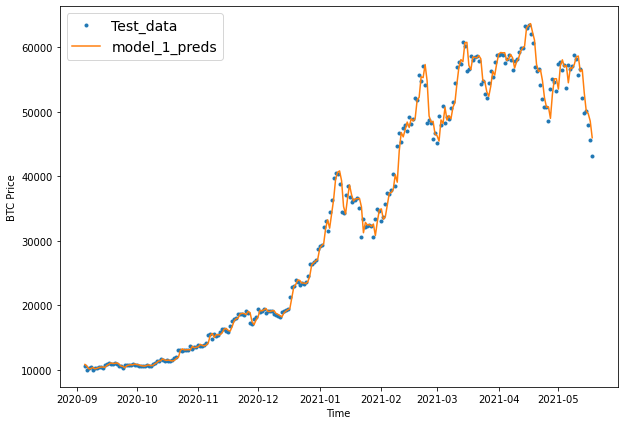

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=30, horizon=HORIZON)
train_windows, test_windows,train_labels,  test_labels = make_train_test_split(full_windows, full_labels)

In [ ]:
tf.random.set_seed(42)

# Construct model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_2.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint("model2")])

INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/assets
INFO:tensorflow:Assets written to: model_experiments/model2/as

In [ ]:
model_2_preds = model_preds(model_2, test_windows)

In [ ]:
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)

In [ ]:
model_2_results

{'mae': 658.0289,
 'mape': 3.0397346,
 'mase': 1.1502408,
 'mse': 1417081.0,
 'rmse': 1190.4121}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

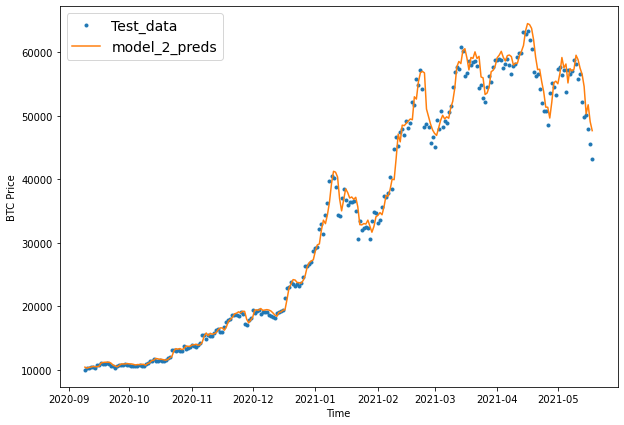

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=30, horizon=7)
train_windows, test_windows,train_labels,  test_labels = make_train_test_split(full_windows, full_labels)

In [ ]:
tf.random.set_seed(42)

# Construct model
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(7, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_3.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint("model3")])

INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/assets
INFO:tensorflow:Assets written to: model_experiments/model3/as

In [ ]:
model_3 = tf.keras.models.load_model("/content/model_experiments/model3")

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1228.1417 - mae: 1228.1417


[1228.1417236328125, 1228.1417236328125]

In [ ]:
model_3_preds = model_preds(model_3, test_windows)
model_3_preds[:2]

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[9233.328, 9332.702, 9363.651, 9442.775, 9401.978, 9414.001,
        9280.01 ],
       [8911.084, 9065.984, 9113.08 , 9026.601, 8990.093, 9000.148,
        9053.433]], dtype=float32)>

In [ ]:
test_labels.shape, model_3_preds.shape

((551, 7), TensorShape([551, 7]))

## Modify EvalutaePreds Function

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy().mean(),
          "mse": mse.numpy().mean(),
          "rmse": rmse.numpy().mean(),
          "mape": mape.numpy().mean(),
          "mase": mase.numpy().mean()}

In [ ]:
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)

In [ ]:
model_3_results

{'mae': 1228.1417,
 'mape': 5.4698334,
 'mase': 2.1854093,
 'mse': 5323686.5,
 'rmse': 1412.9115}

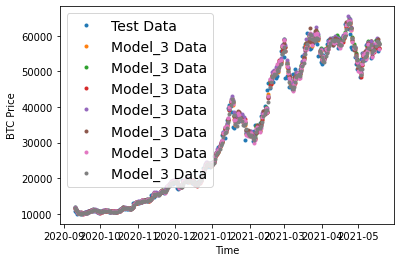

In [ ]:
offset = 300
plot_time_series(X_test[-len(test_windows):], test_labels[:, 0], start = offset, label  ="Test Data")
plot_time_series(X_test[-len(test_windows):], model_3_preds, start = offset, label  ="Model_3 Data")



## Compare model results so far

In [ ]:
comparision = pd.DataFrame({"naive": naive_results,
                            "model_1": model_1_results,
                            "model_2": model_2_results,
                            "model_3": model_3_results}, index = ["mae"])
comparision

,naive,model_1,model_2,model_3
mae,567.980225,568.549805,658.02887,1228.141724


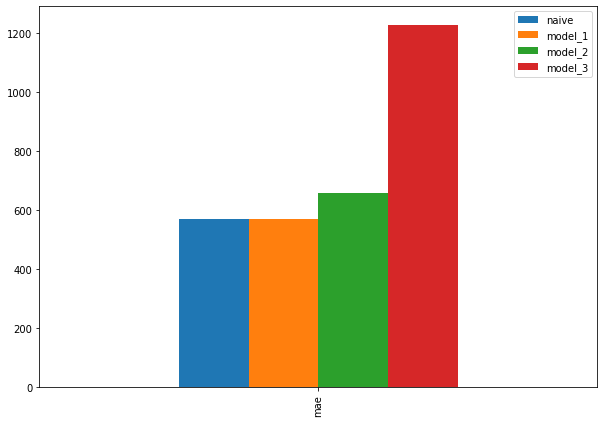

In [ ]:
comparision.plot(kind = "bar", figsize = (10,7))

## Model 4

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
train_windows, test_windows,train_labels,  test_labels = make_train_test_split(full_windows, full_labels)

In [ ]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
train_windows[0].shape

(7,)

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis =1))

In [ ]:
tf.random.set_seed(42)
model_4 = keras.Sequential([
                      expand_dims_layer,
                      layers.Conv1D(128, 7, padding = "causal", activation="relu"),
                      layers.Dense(HORIZON)
])

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
model_4.fit(train_windows, train_labels, epochs= 100, batch_size = 128, callbacks = [create_model_checkpoint("Model4")],
            validation_data = (test_windows, test_labels))

Epoch 1/100
18/18 [==============================] - 1s 11ms/step - loss: 1486.8625 - mae: 1486.8625 - val_loss: 1494.0219 - val_mae: 1494.0219
INFO:tensorflow:Assets written to: model_experiments/Model4/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 359.4607 - mae: 359.4607 - val_loss: 1882.3615 - val_mae: 1882.3615
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 237.6436 - mae: 237.6436 - val_loss: 1228.3146 - val_mae: 1228.3146
INFO:tensorflow:Assets written to: model_experiments/Model4/assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 208.6003 - mae: 208.6003 - val_loss: 1095.6528 - val_mae: 1095.6528
INFO:tensorflow:Assets written to: model_experiments/Model4/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 197.1489 - mae: 197.1489 - val_loss: 1088.0098 - val_mae: 1088.0098
INFO:tensorflow:Assets written to: model_experiments/Model4/assets
Epoch 6/100
18/18 [=====

In [ ]:
train_windows[0]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [ ]:
model_4 =tf.keras.models.load_model("/content/model_experiments/Model4")

In [ ]:
model_4_preds =model_preds(model_4, test_windows)

In [ ]:
model_4_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([8897.537, 8793.336], dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)

In [ ]:
model_4_results

{'mae': 570.39935,
 'mape': 2.5455723,
 'mase': 1.0020337,
 'mse': 1182763.1,
 'rmse': 1087.5492}

In [ ]:
test_labels[:2]

array([[8798.04205463],
       [9081.18687849]])

## Model 5

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
train_windows, test_windows,train_labels,  test_labels = make_train_test_split(full_windows, full_labels)

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis =1))

In [ ]:
tf.random.set_seed(42)
model_5= keras.Sequential([
                           #layers.Input(shape = (WINDOW_SIZE)),
                           expand_dims_layer,
                           layers.LSTM(128, return_sequences=1, activation="relu"),
                           layers.Conv1D(128, 5, padding = "causal", activation="relu"),
                           layers.Dense(HORIZON)
])
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
model_5.fit(train_windows, train_labels, epochs= 100, batch_size = 128, callbacks = [create_model_checkpoint("Model5")],
            validation_data = (test_windows, test_labels))

Epoch 1/100
18/18 [==============================] - 2s 26ms/step - loss: 2481.1802 - mae: 2481.1802 - val_loss: 8725.1855 - val_mae: 8725.1855
INFO:tensorflow:Assets written to: model_experiments/Model5/assets
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 531.1354 - mae: 531.1354 - val_loss: 1098.2024 - val_mae: 1098.2024
INFO:tensorflow:Assets written to: model_experiments/Model5/assets
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 224.6337 - mae: 224.6337 - val_loss: 1035.2129 - val_mae: 1035.2129
INFO:tensorflow:Assets written to: model_experiments/Model5/assets
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 176.3823 - mae: 176.3823 - val_loss: 1045.2590 - val_mae: 1045.2590
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 173.0992 - mae: 173.0992 - val_loss: 942.3556 - val_mae: 942.3556
INFO:tensorflow:Assets written to: model_experiments/Model5/assets
Epoch 6/100
18/18 [====

In [ ]:
model_5 = tf.keras.models.load_model("/content/model_experiments/Model5")

In [ ]:
model_5_preds =model_preds(model_5, test_windows)

In [ ]:
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

In [ ]:
model_5_results

{'mae': 572.9033,
 'mape': 2.5838635,
 'mase': 1.0064324,
 'mse': 1178627.6,
 'rmse': 1085.6461}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Make a multivariate Time series

In [ ]:
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
bitcoin_prices_block = bitcoin_prices.copy()

In [ ]:
bitcoin_prices_block["Block_reward"] = None

In [ ]:
block_reward_3_days = (block_reward_3_datetime- bitcoin_prices_block.index[0]).days
block_reward_4_days = (block_reward_4_datetime-bitcoin_prices_block.index[0]).days

In [ ]:
block_reward_4_days, block_reward_3_days

(2414, 1012)

In [ ]:
bitcoin_prices_block.tail()

,Price,Block_reward
Date,,
2021-05-14,49764.132082,None
2021-05-15,50032.693137,None
2021-05-16,47885.625255,None
2021-05-17,45604.615754,None
2021-05-18,43144.471291,None


In [ ]:
bitcoin_prices_block["Block_reward"][:block_reward_3_datetime] = block_reward_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bitcoin_prices_block["Block_reward"][block_reward_3_datetime:block_reward_4_datetime] = block_reward_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bitcoin_prices_block["Block_reward"][block_reward_4_datetime:] = block_reward_4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


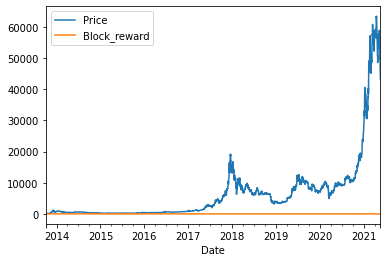

In [ ]:
bitcoin_prices_block.plot()

In [ ]:
from sklearn.preprocessing import minmax_scale
multidf = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "Block_reward"]]), columns = ["Price", "BR"],
                       index  =bitcoin_prices_block.index)

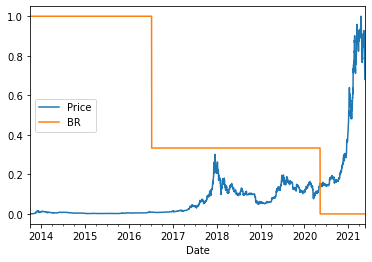

In [ ]:
multidf.plot()

In [ ]:
bitcoin_prices_windowed = bitcoin_prices.copy()

In [ ]:
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price + {i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)

In [ ]:
bitcoin_prices_windowed.head()

,Price,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis =1).astype(np.float32)
y = bitcoin_prices_windowed.dropna().Price.astype(np.float32)

In [ ]:
X.head()

,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,
2013-10-08,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
split_size = int(0.8*(len(X)))
X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test =  y[:split_size], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model6 

In [ ]:
tf.random.set_seed(42)

# Construct model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
                #metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_6.fit(x=X_train, # train windows of 7 timesteps of Bitcoin prices
            y=y_train, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks = [create_model_checkpoint("model6")])

Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 901.1083 - val_loss: 2391.3074
INFO:tensorflow:Assets written to: model_experiments/model6/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 248.6957 - val_loss: 1396.7283
INFO:tensorflow:Assets written to: model_experiments/model6/assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 177.2988 - val_loss: 859.0771
INFO:tensorflow:Assets written to: model_experiments/model6/assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 150.1085 - val_loss: 812.3403
INFO:tensorflow:Assets written to: model_experiments/model6/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 140.8277 - val_loss: 747.3796
INFO:tensorflow:Assets written to: model_experiments/model6/assets
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 132.6653 - val_loss: 714.2393
INFO:tensorflow:Assets written to: model_exp

In [ ]:
model_6 = keras.models.load_model("/content/model_experiments/model6")

In [ ]:
model_6_preds =model_preds(model_6, X_test)

In [ ]:
model_6_results = evaluate_preds(y_test, model_6_preds)

In [ ]:
model_6_results

{'mae': 566.3005,
 'mape': 2.5617404,
 'mase': 0.9948331,
 'mse': 1149529.9,
 'rmse': 1072.1613}

In [ ]:
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

In [ ]:
model_6_results

{'mae': 566.3005,
 'mape': 2.5617404,
 'mase': 0.9948331,
 'mse': 1149529.9,
 'rmse': 1072.1613}

## Model 7 N-Beats

In [ ]:
class n_beats(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
  
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons =n_neurons
    self.n_layers = n_layers

    self.hidden = [keras.layers.Dense(n_neurons, activation="relu") for i in range(n_layers)]
    self.theta_layer = keras.layers.Dense(theta_size, activation="linear", name = "theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
dummy_nbeats_block_layer =n_beats(input_size=WINDOW_SIZE,
                                  theta_size = WINDOW_SIZE+HORIZON,
                                  horizon = HORIZON,
                                  n_neurons =128,
                                  n_layers = 4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis =0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast =dummy_nbeats_block_layer(dummy_inputs)
tf.squeeze(backcast.numpy()), tf.squeeze(forecast.numpy())

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([-0.46348718,  0.10944453, -0.43355346,  0.9360242 , -0.35703537,
        -0.17927602, -0.34048367], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.43979022>)

## Creating data and getting it ready for n_beats

In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy()

In [ ]:
bitcoin_prices_nbeats.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+ {i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods = i+1)

In [ ]:
bitcoin_prices_nbeats.head()

,Price,Price+ 1,Price+ 2,Price+ 3,Price+ 4,Price+ 5,Price+ 6,Price+ 7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
split_size = int(0.8*len(bitcoin_prices_nbeats))
X = bitcoin_prices_nbeats.dropna().drop("Price", axis =1)
y = bitcoin_prices_nbeats.dropna().Price

In [ ]:
X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 551, 551)

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_data = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_data = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024

train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [ ]:
N_EPOCHS = 5000
N_NEURONS  =512
N_LAYERS =4
N_STACKS = 30

INPUT_SIZE  =WINDOW_SIZE*HORIZON
THETA_SIZE = WINDOW_SIZE+ HORIZON

In [ ]:
tensor1 = tf.range(10)+5
tensor2 = tf.range(10)
sub =layers.subtract([tensor1, tensor2])
sub.numpy()

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [ ]:
# tf.random.set_seed(42)

# n_beats_block_layer = n_beats(input_size = INPUT_SIZE,
#                               theta_size = THETA_SIZE,
#                               horizon = HORIZON,
#                               n_neurons = N_NEURONS,
#                               n_layers = N_LAYERS)
# stack_input = layers.Input(shape = (INPUT_SIZE), name ="stack_inp")

# residuals, forecast = n_beats_block_layer(stack_input)

# for i, _ in enumerate(range(N_STACKS -1)):
  
#   backcast, block_forecast = n_beats(INPUT_SIZE, THETA_SIZE,
#                                      HORIZON, N_NEURONS, 
#                                      N_LAYERS)(residuals)
#   residuals = layers.subtract([residuals, backcast])
#   forecast = layers.add([block_forecast, forecast])

# model_7 = tf.keras.Model(stack_input, forecast)
# model_7.compile(loss = "mae", 
#                 optimizer = tf.keras.optimizers.Adam())
# model_7.fit(train_data, validation_data = test_data, epochs  =N_EPOCHS, 
#             callbacks = [tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=1),
#                          tf.keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1)])


3/3 [==============================] - 6s 2s/step - loss: 968.4354 - val_loss: 7028.5454


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fba97b22440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 9/5000


KeyboardInterrupt: ignored

In [ ]:
# model_7_preds = model_preds(model_7, test_data)
# model_7_results = evaluate_preds(y_test, model_7_preds)
# model_7_results

## Model 8

In [ ]:
# def get_ensemble_models(horizon =HORIZON,
#                         train_data = train_data,
#                         test_data =test_data,
#                         n_epochs = 1000,
#                         n_iter = 10,
#                         loss_fn = ["mae", "mse", "mape"]):
#   ensemble_models  =[]
#   for n_iter in range(n_iter):
#     for loss_fn in loss_fn:
#       model = tf.keras.Sequential([
#                                    layers.Dense(128,kernel_initializer = "he_normal", activation="relu" ),
#                                    layers.Dense(128,kernel_initializer = "he_normal", activation="relu"),
#                                    layers.Dense(HORIZON)
#       ])
#       model.compile(loss = loss_fn,
#                     optimizer =keras.optimizers.Adam(),
#                     metrics = ["mae", "mse"])
#       model.fit(train_data, validation_data = test_data,
#                 epochs = n_epochs, callbacks = [tf.keras.callbacks.EarlyStopping(patience =200, restore_best_weights=1),
#                                                 tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                                               patience = 100, verbose=1)])
#       ensemble_models.append(model)
#   return ensemble_models
# ensemble_models = get_ensemble_models()

In [ ]:
# def make_ensemble_preds(ensemble_models, data):
#   ensemble_preds = []
#   for model in ensemble_models:
#     preds = model.predict(data) # make predictions with current ensemble model
#     ensemble_preds.append(preds)
#   return tf.constant(tf.squeeze(ensemble_preds))
# ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
#                                      data=test_dataset)

In [ ]:
# def get_upper_lower(preds):
#   std  =tf.math.reduce_std(preds)

#   interval =1.96*std

#   preds_mean = tf.math.reduce_mean(preds, axis =0)
#   upper, lower = preds_mean + interval, preds_mean-interval
#   return upper, lower
# upper, lower = get_upper_lower(ensemble_preds)

In [ ]:
# ensemble_median = np.median(ensemble_preds, axis=0)

# # Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
# offset=500
# plt.figure(figsize=(10, 7))
# plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
# plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
# plt.xlabel("Date")
# plt.ylabel("BTC Price")
# plt.fill_between(X_test.index[offset:], 
#                  (lower)[offset:], 
#                  (upper)[offset:], label="Prediction Intervals")
# plt.legend(loc="upper left", fontsize=14);

## Future Predicting Model

In [ ]:
bitcoin_prices_windowed.head()

,Price,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X_all = bitcoin_prices_windowed.dropna().drop("Price", axis =1).to_numpy()
y_all = bitcoin_prices_windowed.dropna().Price.to_numpy()


array([[  121.795     ,   120.65533   ,   121.33866   , ...,
          108.58483   ,   125.455     ,   123.65499   ],
       [  123.033     ,   121.795     ,   120.65533   , ...,
          118.67466   ,   108.58483   ,   125.455     ],
       [  124.049     ,   123.033     ,   121.795     , ...,
          121.33866   ,   118.67466   ,   108.58483   ],
       ...,
       [50032.69313676, 49764.1320816 , 52147.82118698, ...,
        55715.54665129, 58102.19142623, 58788.20967893],
       [47885.62525472, 50032.69313676, 49764.1320816 , ...,
        56573.5554719 , 55715.54665129, 58102.19142623],
       [45604.61575361, 47885.62525472, 50032.69313676, ...,
        52147.82118698, 56573.5554719 , 55715.54665129]])

In [ ]:
features_dataset_all  = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all =tf.data.Dataset.from_tensor_slices(y_all)

full_dataset = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
full_dataset = full_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.random.set_seed(42)
model_9  =tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
])
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(full_dataset,
            epochs=100,
            verbose=0    ) # don't print out anything, we've seen this all before

In [ ]:
full_dataset

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
INTO_FUTURE = 14
def make_future_forecast(model, values, window_size = WINDOW_SIZE, into_future =INTO_FUTURE):
  forecasts =[]
  last_window = values[-window_size:]
  print(last_window.shape)
  for i in range(into_future):
    #model.fit(tf.expand_dims(last_window, axis=1), epochs =100, verbose =0)
    future_pred = model.predict(tf.expand_dims(last_window, axis =0))
    forecasts.append(future_pred)
    print(f"Prediction on {tf.squeeze(last_window)}:\n {future_pred}")
    last_window = np.append(last_window, future_pred)[-window_size:]
    
  return tf.squeeze(forecasts)

In [ ]:
forecasts = make_future_forecast(model_9, y_all)

(7,)
Prediction on [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086]:
 [[55881.53]]
Prediction on [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55881.53125   ]:
 [[51063.074]]
Prediction on [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55881.53125    51063.07421875]:
 [[48624.887]]
Prediction on [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55881.53125    51063.07421875 48624.88671875]:
 [[48238.29]]
Prediction on [47885.62525472 45604.61575361 43144.47129086 55881.53125
 51063.07421875 48624.88671875 48238.2890625 ]:
 [[48016.418]]
Prediction on [45604.61575361 43144.47129086 55881.53125    51063.07421875
 48624.88671875 48238.2890625  48016.41796875]:
 [[47004.754]]
Prediction on [43144.47129086 55881.53125    51063.07421875 48624.88671875
 48238.2890625  48016.41796875 47004.75390625]:
 [[48464.33]]
Prediction on [55881.53125    51063

In [ ]:
forecasts

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([55881.53 , 51063.074, 48624.887, 48238.29 , 48016.418, 47004.754,
       48464.33 , 54163.504, 49864.215, 47810.64 , 48372.21 , 49084.746,
       48913.086, 50547.547], dtype=float32)>

In [ ]:
def get_future_dates(start_date, into_future, offset = 1):
  start_date = start_date + np.timedelta64(offset, "D")
  last_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, last_date, dtype= "datetime64[D]")

In [ ]:
last_index = bitcoin_prices.index[-1]
first_index  =bitcoin_prices.index[0]

In [ ]:
future_dates = get_future_dates(last_index, 14)

In [ ]:
future_dates

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
first_index

Timestamp('2013-10-01 00:00:00')

In [ ]:
future_dates = np.insert(future_dates, obj = 0, values = last_index)
forecasts  =np.insert(forecasts, 0, bitcoin_prices.Price[-1])
future_dates, forecasts

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55881.53 , 51063.074, 48624.887, 48238.29 , 48016.418,
        47004.754, 48464.33 , 54163.504, 49864.215, 47810.64 , 48372.21 ,
        49084.746, 48913.086, 50547.547], dtype=float32))

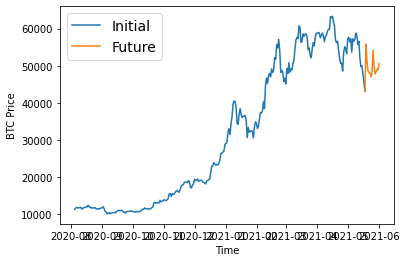

In [ ]:
plt.plot(figsize = (20,7))
plot_time_series(bitcoin_prices.index, bitcoin_prices.Price, format = "-", start = 2500, label = "Initial")
plot_time_series(future_dates, forecasts, format="-", label = "Future")

## Turkey Problem

In [ ]:
btc_price_turkey = bitcoin_prices.Price.to_numpy()

In [ ]:
btc_price_turkey

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [ ]:
btc_price_turkey[-1]  /= 100

In [ ]:
btc_price_turkey

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361,   431.44471291])

In [ ]:
btc_dates_turkey = bitcoin_prices.index.to_numpy()
btc_dates_turkey

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', ...,
       '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
       '2021-05-18T00:00:00.000000000'], dtype='datetime64[ns]')

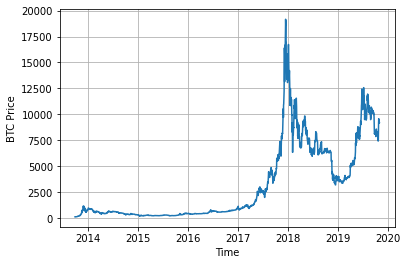

In [ ]:
plot_time_series(btc_dates_turkey[:len(X_train)], btc_price_turkey[:len(y_train)], format= "-")

In [ ]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_split(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
model_10=  keras.models.clone_model(model_1)
model_10.compile(loss = "mae", 
                 optimizer = keras.optimizers.Adam())
model_10.fit(X_train, y_train, epochs =50, validation_data=(X_test, y_test),
             batch_size =128 ,
             callbacks = [create_model_checkpoint("mdoel_10_turkey")])

In [ ]:
model_10 = keras.models.load_model("/content/model_experiments/mdoel_10_turkey")
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 648.5377


648.5376586914062

In [ ]:
model_10_preds = model_preds(model_10, X_test)
model_10_preds

In [ ]:
model_10_results = evaluate_preds(y_test, model_10_preds)

In [ ]:
model_10_results

{'mae': 17106.129,
 'mape': 121.0328,
 'mase': 26.471788,
 'mse': 612724740.0,
 'rmse': 23668.271}

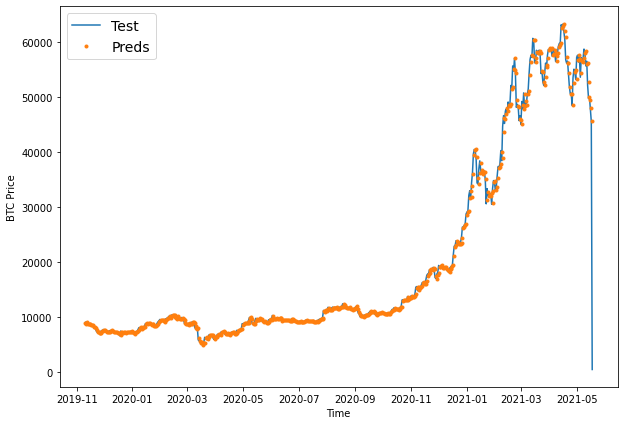

In [ ]:
plt.figure(figsize =(10, 7))
# plot_time_series(btc_dates_turkey[:len(X_train)], btc_price_turkey[:len(y_train)], format ="g", label  ='Train')
# plot_time_series(btc_dates_turkey[len(X_train):], btc_price_turkey[len(y_train):], format ="b", label  ='Test')
plot_time_series(btc_dates_turkey[-len(X_test):], btc_price_turkey[-len(y_test):], format ="-", label  ='Test')
plot_time_series(btc_dates_turkey[-len(X_test):], model_10_preds, format = ".", label="Preds")

In [ ]:
len(X_train)

2224

In [ ]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              #"model_8_NBEATs": model_7_results,
                              #"model_9_ensemble": ensemble_results,
                              "model_10_turkey": model_10_results}).T
model_results.head(10)


,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.549805,1.172588e+06,1082.860840,2.549229,0.998785
model_2_dense_w30_h1,658.028870,1.417081e+06,1190.412109,3.039735,1.150241
model_3_dense_w30_h7,1228.141724,5.323686e+06,1412.911499,5.469833,2.185409
model_4_CONV1D,570.399353,1.182763e+06,1087.549194,2.545572,1.002034
model_5_LSTM,572.903320,1.178628e+06,1085.646118,2.583863,1.006432
model_6_multivariate,566.300476,1.149530e+06,1072.161255,2.561740,0.994833
model_10_turkey,17106.128906,6.127247e+08,23668.271484,121.032799,26.471788


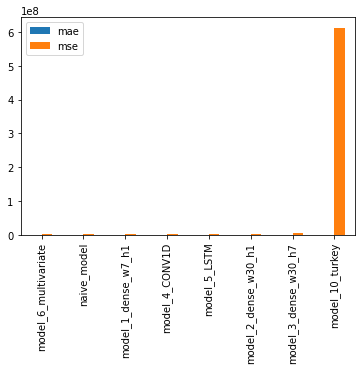

In [ ]:

model_results[["mae", "mse"]].sort_values("mae").plot(kind ="bar")

In [ ]:
model_results = pd.DataFrame(minmax_scale(model_results[["mae", "mse"]]), columns=[["mae", "mse"]], index = model_results.index)

In [ ]:
model_results

,mae,mse
naive_model,0.000102,0.000000
model_1_dense_w7_h1,0.000136,0.000041
model_2_dense_w30_h1,0.005546,0.000441
model_3_dense_w30_h7,0.040015,0.006828
model_4_CONV1D,0.000248,0.000058
model_5_LSTM,0.000399,0.000051
model_6_multivariate,0.000000,0.000003
model_10_turkey,1.000000,1.000000
